# Finding which cities is Australia is best suited for starting Cafes and Restaurants

## Introduction

Australia is a multi-cultural country which has got more than 200 nationalities living in the country. The diversity in population brought numerous cuisines from all over the world to Australia. The people of Australia are very keen to explore different cusine from across the globe. The aim of this project is to analyze which city in Australia is best suited for starting a new restaurant and cafe business.

## Data Collection

Data used in this project are as follows

### Venue Data
The venue data has been extracted using the Foursquare API. This data contains venue recommendations for all cities in Australia and is used to study the popular venues of different neighborhoods.

### Australian Cities
Main australian cities are obtained from the following url
https://www.latlong.net/category/cities-14-15.html. 
The data is read into a pandas data frame using the read_html() method. 

### Coordinates
The geographical coordinates for Australia data has been obtained from the GeoPy library in python. 



### Importing libraries

In [ ]:
!pip install geopy
!pip install geocoder
!pip install folium

import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('All libraries imported.')

     |████████████████████████████████| 98 kB 7.4 MB/s 
All libraries imported.


### Fetching Main cities of Australia

Scraping data from 'https://www.latlong.net/category/cities-14-15.html'.

In [ ]:
aus_cities = pd.read_html('https://www.latlong.net/category/cities-14-15.html')[-1]
aus_cities['Cities'] = aus_cities['Place Name'].apply(lambda x: x.split(',')[0])
aus_cities['State'] = aus_cities['Place Name'].apply(lambda x: x.split(',')[1])
aus_cities.drop(['Place Name', 'Latitude',	'Longitude' ], axis=1, inplace=True)
aus_cities.head(5)

,Cities,State
0,Tamworth,NSW
1,Queanbeyan,NSW
2,Penrith,NSW
3,Newcastle,NSW
4,Liverpool,NSW


### Data Wrangling

Lets look at the different values for States present in the State column.

In [ ]:
aus_cities['State'].value_counts()

 NSW                   21
 WA                    17
 VIC                   17
 QLD                   11
 SA                     9
 Australia              4
 Queensland             3
 Tasmania               3
 Northern Territory     2
 Greenvale              1
 TAS                    1
Name: State, dtype: int64

Some states like QLD is represented as Queensland and Tasmania as TAS. Changing state names which are represented as different names to a common name.

In [ ]:
aus_cities['State'] = aus_cities['State'].apply(lambda x: x.replace('Queensland','QLD'))
aus_cities['State'] = aus_cities['State'].apply(lambda x: x.replace('Tasmania','TAS'))
aus_cities['State'] = aus_cities['State'].apply(lambda x: x.replace('Northern Territory','NT'))
aus_cities['State'] = aus_cities['State'].apply(lambda x: x.replace('Australia','QLD'))
aus_cities['State'] = aus_cities['State'].apply(lambda x: x.replace('Greenvale','VIC'))



States are cleaned and propelry organized

In [ ]:
aus_cities['State'].value_counts()

 NSW    21
 QLD    18
 VIC    18
 WA     17
 SA      9
 TAS     4
 NT      2
Name: State, dtype: int64

Now that the data is much easier to interpret, lets display the dataframe created.

In [ ]:
aus_cities

,Cities,State
0,Tamworth,NSW
1,Queanbeyan,NSW
2,Penrith,NSW
3,Newcastle,NSW
4,Liverpool,NSW
...,...,...
84,Gladstone QLD,QLD
85,Gosford,NSW
86,Mount Gambier,SA
87,Sydney,NSW


Fetch the coordinates of the cities using Geopy

In [ ]:
aus_cities['Latitude'] = None
aus_cities['Longitude'] = None

for i, neigh in enumerate(aus_cities['Cities']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Australia'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    aus_cities.loc[i, 'Latitude'] = latitude
    aus_cities.loc[i, 'Longitude'] = longitude

aus_cities.head(10)

,Cities,State,Latitude,Longitude
0,Tamworth,NSW,-31.0906,150.929
1,Queanbeyan,NSW,-35.355,149.233
2,Penrith,NSW,-33.7537,150.698
3,Newcastle,NSW,-32.9281,151.773
4,Liverpool,NSW,-33.9224,150.923
5,Lithgow,NSW,-33.4828,150.153
6,Goulburn,NSW,-34.757,149.716
7,Dubbo,NSW,-32.247,148.601
8,Cessnock NSW,QLD,-32.8329,151.355
9,Campbelltown,NSW,-34.8809,138.662


### Data Visualization

To understand our data better, we can see how many cities are in each states.

In [ ]:
aus_main_cities = aus_cities.groupby('State')['Cities'].nunique()
aus_main_cities

State
 NSW    21
 NT      2
 QLD    18
 SA      9
 TAS     4
 VIC    18
 WA     17
Name: Cities, dtype: int64

We can now plot this data.

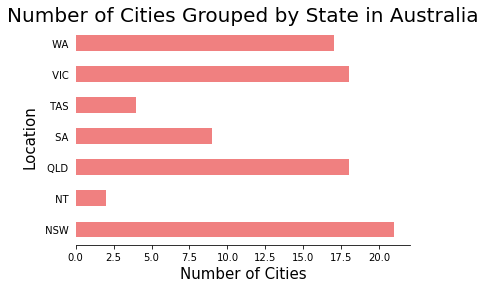

In [ ]:
fig = plt.figure(figsize=(12,8))
%matplotlib inline
ax = aus_main_cities.plot(kind='barh', color='lightcoral')
ax.set_title('Number of Cities Grouped by State in Australia', fontsize=20)
ax.set_xlabel('Number of Cities', fontsize=15)
ax.set_ylabel('Location', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(which='major', left=False)
fig.tight_layout()

###Visualize the cities using folium

In [ ]:
address = 'Australia'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Australia are {}, {}.'.format(latitude, longitude))

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinates of Australia are -24.7761086, 134.755.


Now we can plot the map.

In [ ]:
map_aus = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(aus_cities['Latitude'], aus_cities['Longitude'], aus_cities['State'], aus_cities['Cities']):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_aus)  
    
map_aus

### Using Foursquare API

Exploring the first city Tamworth in the dataframe using Foursquare API.

In [ ]:
city_name = aus_cities.loc[0, 'Cities']
city_lat = aus_cities.loc[0, 'Latitude']
city_long = aus_cities.loc[0, 'Longitude']

print("The neighborhood is {} and it's geographical coordinates are {} latitude and {} longitude".format(city_name,
                                                                                                        city_lat, city_long))

The neighborhood is Tamworth and it's geographical coordinates are -31.090569999999957 latitude and 150.92862000000002 longitude


ERxtracting the top 200 venues near Tamworth with a radius of 1000m or 1km. In order to do this, we will start by creating a url.

In [ ]:
LIMIT = 200
radius = 1000
CLIENT_ID = 'BYNANT0XDRWKUDYCILOEHWEL2VZTTRJ2OM1HCJ5DTV10XLOD'
CLIENT_SECRET = 'EYJ1HUH40H1RP5YZAN45L1M1JHSMAO1JJFFKYRVJAIT4L1OG'
VERSION = '20200717'

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    city_lat, 
    city_long, 
    radius, 
    LIMIT)

We can now use the GET method to get our results.

In [ ]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '61008f2d20d0b1401237acf1'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4bf5ec2c004ed13a87af41a0-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1e0931735',
         'name': 'Coffee Shop',
         'pluralName': 'Coffee Shops',
         'primary': True,
         'shortName': 'Coffee Shop'}],
       'id': '4bf5ec2c004ed13a87af41a0',
       'location': {'address': '306 Peel St',
        'cc': 'AU',
        'city': 'Tamworth',
        'country': 'Australia',
        'distance': 185,
        'formattedAddress': ['306 Peel St', 'Tamworth NSW 2340', 'Australia'],
        'labeledLatLngs': [{'label': 'display',
          'lat': -31.088941767740536,
          '

**Function to extract the categories of venues.** 

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

**Clean and store JSON to DF**

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Addimi Espresso,Coffee Shop,-31.088942,150.928202
1,The Pig & Tinder Box,Gastropub,-31.092430,150.931240
2,West Diggers,Rock Club,-31.089829,150.927047
3,JB Hi-Fi,Electronics Store,-31.090260,150.930630
4,Centrepoint Tamworth,Shopping Mall,-31.090621,150.930645


We can check how many venues were returned by Foursquare.

In [ ]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), city_name))

25 venues were returned for Tamworth by Foursquare


### Generalizing Foursquare API

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Cities', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Applying the foursquare API for all cities in Australia to get the nearby venues

In [ ]:
aus_venues = getNearbyVenues(names=aus_cities['Cities'], latitudes=aus_cities['Latitude'], longitudes=aus_cities['Longitude'], radius=radius)

Tamworth
Queanbeyan
Penrith
Newcastle
Liverpool
Lithgow
Goulburn
Dubbo
Cessnock NSW
Campbelltown
Broken Hill
Blue Mountains
Bathurst
Armidale
Wanneroo
Gosnells
Spearwood
Cannington
Bayswater
Armadale
Rockingham
Karratha
Mandurah
Kalgoorlie
Joondalup
Fremantle
Busselton
Bunbury
Albany
Warrnambool
Wangaratta
Swan Hill
Sale
Shepparton
Melton
Latrobe City
Horsham
Geelong
Frankston
Ballarat
Benalla
Bairnsdale
Ararat
Devonport
Burnie
Hobart
Whyalla
Victor Harbor
Port Pirie
Port Augusta
Port Adelaide
Murray Bridge
Thuringowa
Redland City
Toowoomba
Rockhampton
Mackay
Logan City
Bundaberg
Palmerston
Canberra
Sunshine Coast
Gold Coast
Melbourne
Adelaide
Launceston
North Adelaide
Townsville City
Cairns City
Perth
Mildura
Ziyou Today
Coffs Harbour
Orange
Bendigo
Albury
Swan
Ipswich
Wollongong
Darwin
Terrey Hills
Bankstown NSW
Westmead
Brisbane
Gladstone QLD
Gosford
Mount Gambier
Sydney
Glenore Grove


Lets see what our dataframe looks like.

In [ ]:
print(aus_venues.shape)
aus_venues.head(10)

(2837, 7)


,Cities,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Tamworth,-31.09057,150.92862,Addimi Espresso,-31.088942,150.928202,Coffee Shop
1,Tamworth,-31.09057,150.92862,The Pig & Tinder Box,-31.092430,150.931240,Gastropub
2,Tamworth,-31.09057,150.92862,West Diggers,-31.089829,150.927047,Rock Club
3,Tamworth,-31.09057,150.92862,JB Hi-Fi,-31.090260,150.930630,Electronics Store
4,Tamworth,-31.09057,150.92862,Centrepoint Tamworth,-31.090621,150.930645,Shopping Mall
5,Tamworth,-31.09057,150.92862,Inland Cafe,-31.091981,150.930970,Café
6,Tamworth,-31.09057,150.92862,Hog's Breath Cafe,-31.089066,150.928259,Steakhouse
7,Tamworth,-31.09057,150.92862,Safari Club,-31.088905,150.928175,African Restaurant
8,Tamworth,-31.09057,150.92862,BP,-31.091276,150.924936,Gas Station
9,Tamworth,-31.09057,150.92862,The Albert,-31.087667,150.926909,Pub


Checking venues of each cities

In [ ]:
aus_venues.groupby('Cities', as_index=False).count()

,Cities,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adelaide,100,100,100,100,100,100
1,Albany,26,26,26,26,26,26
2,Albury,39,39,39,39,39,39
3,Ararat,14,14,14,14,14,14
4,Armadale,21,21,21,21,21,21
...,...,...,...,...,...,...,...
81,Wanneroo,14,14,14,14,14,14
82,Warrnambool,29,29,29,29,29,29
83,Westmead,9,9,9,9,9,9
84,Whyalla,6,6,6,6,6,6


We can now check how many unique categories are there in our data.

In [ ]:
print("There are {} unique categories".format(aus_venues['Venue Category'].nunique()))

There are 255 unique categories


### Analyzing each Cities

Applying One-hot Encoding to see which categories belong in which cities.

In [ ]:
aus_onehot = pd.get_dummies(aus_venues[['Venue Category']], prefix="", prefix_sep="")
aus_onehot.head()

,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bistro,Boat Launch,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,...,Social Club,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Travel Lounge,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Zoo
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Adding Cities column to the one-hot encoded dataframe.

In [ ]:
aus_onehot['Cities'] = aus_venues['Cities']
aus_onehot.head()

,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bistro,Boat Launch,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,...,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Travel Lounge,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Zoo,Cities
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Tamworth
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Tamworth
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Tamworth
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Tamworth
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Tamworth


Moving the Cities column to the first column.

In [ ]:
temp = list(aus_onehot.columns)

if 'Cities' in temp:
    temp.remove('Cities')
    
fixed_columns = ['Cities'] + temp
aus_onehot = aus_onehot[fixed_columns]

aus_onehot.head()

,Cities,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bistro,Boat Launch,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,...,Social Club,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Travel Lounge,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Zoo
0,Tamworth,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Tamworth,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Tamworth,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Tamworth,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Tamworth,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we can groupby cities and take the mean for all categories.

In [ ]:
aus_grouped = aus_onehot.groupby('Cities', sort=False).mean().reset_index()
print(aus_grouped.shape)
aus_grouped.head(10)

(86, 256)


,Cities,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bistro,Boat Launch,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,...,Social Club,South American Restaurant,South Indian Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Travel Lounge,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Zoo
0,Tamworth,0.04,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.040000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.040000,0.0,0.120000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,Queanbeyan,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.062500,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.125000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.125000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,Penrith,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.014493,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.014493,0.0,0.0,0.0,0.0,0.014493,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.014493,0.0,0.014493,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.014493,0.000000,0.0,0.028986,0.0,0.043478,0.014493,0.0,0.0,0.014493,0.0,0.0,0.057971,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.014493,0.000,0.000000,0.0,0.0,0.0,0.0,0.014493,0.000000,0.0,0.0,0.0,0.0,0.0
3,Newcastle,0.00,0.0,0.0,0.0,0.0,0.010638,0.0,0.0,0.0,0.000000,0.000,0.010638,0.0,0.0,0.010638,0.000000,0.085106,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.010638,0.0,0.0,0.0,0.0,0.021277,0.010638,0.0,0.0,0.000000,0.0,0.010638,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.010638,0.000000,0.0,0.010638,0.0,0.021277,0.010638,0.0,0.0,0.000000,0.0,0.0,0.010638,0.010638,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.031915,0.0,0.0,0.0,0.0,0.0
4,Liverpool,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.027778,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.027778,0.0,0.000000,0.0,0.055556,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,Lithgow,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.400000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
6,Goulburn,0.00,0.0,0.0,0.0,0.0,0.045455,0.0,0.0,0.0,0.000000,0.000,0.00000

Displaying the top 5 venues of all neighborhoods.

In [ ]:
num_top_venues = 5

for hood in aus_grouped['Cities']:
    print("----"+hood+"----")
    temp = aus_grouped[aus_grouped['Cities'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Tamworth----
                  venue  freq
0           Supermarket  0.12
1  Fast Food Restaurant  0.12
2                  Café  0.08
3      Department Store  0.08
4           Gas Station  0.04


----Queanbeyan----
             venue  freq
0              Pub  0.12
1             Café  0.12
2      Supermarket  0.12
3  Thai Restaurant  0.12
4             Park  0.12


----Penrith----
                  venue  freq
0                  Café  0.13
1  Fast Food Restaurant  0.09
2       Thai Restaurant  0.06
3           Supermarket  0.04
4     Electronics Store  0.04


----Newcastle----
            venue  freq
0            Café  0.19
1             Bar  0.09
2             Pub  0.05
3      Restaurant  0.04
4  Sandwich Place  0.03


----Liverpool----
                  venue  freq
0                  Café  0.14
1  Fast Food Restaurant  0.11
2  Gym / Fitness Center  0.08
3           Supermarket  0.06
4         Shopping Mall  0.06


----Lithgow----
                venue  freq
0         Supermarket   

Creating a dataframe with the top 10 common venues for each neighborhood.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Cities']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Cities'] = aus_grouped['Cities']

for ind in np.arange(aus_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(aus_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Cities,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tamworth,Supermarket,Fast Food Restaurant,Department Store,Café,African Restaurant,Electronics Store,Steakhouse,Shopping Mall,Noodle House,Gas Station
1,Queanbeyan,Café,Pub,Park,Supermarket,Thai Restaurant,Hotel,Performing Arts Venue,Sandwich Place,Bakery,Pizza Place
2,Penrith,Café,Fast Food Restaurant,Thai Restaurant,Electronics Store,Supermarket,Department Store,Performing Arts Venue,Sandwich Place,Steakhouse,Shopping Mall
3,Newcastle,Café,Bar,Pub,Restaurant,Vietnamese Restaurant,Sandwich Place,Pizza Place,Breakfast Spot,Supermarket,Japanese Restaurant
4,Liverpool,Café,Fast Food Restaurant,Gym / Fitness Center,Sandwich Place,Pharmacy,Department Store,Supermarket,Shopping Mall,Lebanese Restaurant,Coffee Shop
...,...,...,...,...,...,...,...,...,...,...,...
81,Gladstone QLD,Multiplex,Convenience Store,Restaurant,Coffee Shop,Asian Restaurant,Pizza Place,Indian Restaurant,Sandwich Place,Football Stadium,Food Truck
82,Gosford,Pizza Place,Miscellaneous Shop,Café,Playground,Platform,Fast Food Restaurant,Sandwich Place,Pharmacy,Food,Football Stadium
83,Mount Gambier,Café,Fast Food Restaurant,Tourist Information Center,Pub,Hotel,Food & Drink Shop,Shopping Mall,Sandwich Place,Supermarket,Cave
84,Sydney,Café,Coffee Shop,Speakeasy,Hotel,Cocktail Bar,Bar,Shopping Mall,Japanese Restaurant,Hobby Shop,Restaurant


### Clustering neighborhoods

KMeans clustering method to cluster the cities.

Defining a function to plot the Silhouette Score to claculate the score

In [ ]:
def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Checking Optiaus Number of Clusters')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [ ]:
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    cl_df = aus_grouped.drop('Cities', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)

We can now display the scores for different number of clusters and plot the data as well.

[0.6528085464778968, 0.07170039278735021, 0.0713741891245609, 0.13741368663215617, 0.06988789083012038, 0.06636153087346475, 0.03744067390023289, 0.052250862302339454, 0.03973314905965035, 0.0685965541642681, 0.06198458222075982, 0.05023414290569603, 0.05651178782332004, 0.07588165608268391]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


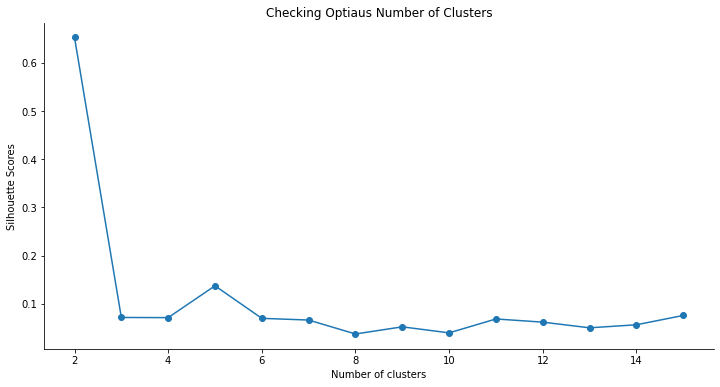

In [ ]:
print(scores)
print(kval)
plot(kval, scores)

We can see that the silhouette scores are not very high even as we increase the number of clusters. This means that the inter-cluster distance between different clusters is not very high over the range of k-values. However, we will try to cluster our data as best as we can. For this, we will use 8 clusters for our clustering model since it provides the highest silhouette score as seen above.

In [ ]:
k = 8

aus_clustering = aus_grouped.drop('Cities', axis=1)
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(aus_clustering) #Can choose any random_state

kmeans.labels_

array([4, 4, 4, 6, 0, 4, 4, 4, 0, 1, 5, 4, 0, 0, 1, 1, 4, 4, 5, 6, 5, 6,
       5, 4, 0, 4, 6, 5, 0, 0, 0, 0, 6, 4, 1, 3, 6, 5, 6, 0, 0, 0, 3, 0,
       6, 0, 0, 3, 5, 7, 4, 4, 4, 4, 5, 5, 3, 5, 5, 6, 4, 6, 6, 6, 6, 6,
       6, 6, 6, 4, 4, 0, 6, 6, 0, 6, 6, 0, 4, 4, 6, 6, 4, 0, 6, 2],
      dtype=int32)

Now we can create a new dataframe that includes cluster labels and the top 10 venues.

In [ ]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
aus_merged = aus_cities
aus_merged = aus_merged.join(neighborhoods_venues_sorted.set_index('Cities'), on='Cities')


Lets view the newly created dataframe.

In [ ]:
print(aus_merged.shape)
aus_merged

(89, 15)


,Cities,State,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tamworth,NSW,-31.0906,150.929,4.0,Supermarket,Fast Food Restaurant,Department Store,Café,African Restaurant,Electronics Store,Steakhouse,Shopping Mall,Noodle House,Gas Station
1,Queanbeyan,NSW,-35.355,149.233,4.0,Café,Pub,Park,Supermarket,Thai Restaurant,Hotel,Performing Arts Venue,Sandwich Place,Bakery,Pizza Place
2,Penrith,NSW,-33.7537,150.698,4.0,Café,Fast Food Restaurant,Thai Restaurant,Electronics Store,Supermarket,Department Store,Performing Arts Venue,Sandwich Place,Steakhouse,Shopping Mall
3,Newcastle,NSW,-32.9281,151.773,6.0,Café,Bar,Pub,Restaurant,Vietnamese Restaurant,Sandwich Place,Pizza Place,Breakfast Spot,Supermarket,Japanese Restaurant
4,Liverpool,NSW,-33.9224,150.923,0.0,Café,Fast Food Restaurant,Gym / Fitness Center,Sandwich Place,Pharmacy,Department Store,Supermarket,Shopping Mall,Lebanese Restaurant,Coffee Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,Gladstone QLD,QLD,-23.858,151.254,6.0,Multiplex,Convenience Store,Restaurant,Coffee Shop,Asian Restaurant,Pizza Place,Indian Restaurant,Sandwich Place,Football Stadium,Food Truck
85,Gosford,NSW,-33.4232,151.343,4.0,Pizza Place,Miscellaneous Shop,Café,Playground,Platform,Fast Food Restaurant,Sandwich Place,Pharmacy,Food,Football Stadium
86,Mount Gambier,SA,-37.8282,140.781,0.0,Café,Fast Food Restaurant,Tourist Information Center,Pub,Hotel,Food & Drink Shop,Shopping Mall,Sandwich Place,Supermarket,Cave
87,Sydney,NSW,-33.8696,151.207,6.0,Café,Coffee Shop,Speakeasy,Hotel,Cocktail Bar,Bar,Shopping Mall,Japanese Restaurant,Hobby Shop,Restaurant


We can visualize the clustering by creating a map.

In [ ]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(aus_merged['Latitude'], aus_merged['Longitude'], aus_merged['Cities'], aus_merged['Cluster Labels']):
  if not np.isnan(cluster):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

We can now view the cities in each cluster and their top 10 most common venues.

### Cluster 1

In [ ]:
aus_merged.loc[aus_merged['Cluster Labels'] == 0, aus_merged.columns[[0] + [1] + list(range(5, aus_merged.shape[1]))]]

,Cities,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Liverpool,NSW,Café,Fast Food Restaurant,Gym / Fitness Center,Sandwich Place,Pharmacy,Department Store,Supermarket,Shopping Mall,Lebanese Restaurant,Coffee Shop
8,Cessnock NSW,QLD,Café,Pub,Fast Food Restaurant,Supermarket,Hotel,Grocery Store,Department Store,Hotel Bar,Discount Store,Coffee Shop
13,Armidale,NSW,Café,Pub,Fast Food Restaurant,Park,Motel,Supermarket,Sandwich Place,Hotel,Gym / Fitness Center,Gas Station
14,Wanneroo,WA,Fast Food Restaurant,Café,Portuguese Restaurant,Restaurant,Department Store,Shopping Mall,Pet Store,Liquor Store,Coffee Shop,Steakhouse
25,Fremantle,WA,Café,Japanese Restaurant,Supermarket,Hostel,Tapas Restaurant,Gas Station,Breakfast Spot,South American Restaurant,Seafood Restaurant,Sandwich Place
29,Warrnambool,VIC,Café,Hotel,Grocery Store,Pub,Multiplex,South American Restaurant,Fast Food Restaurant,Supermarket,Noodle House,Gas Station
30,Wangaratta,VIC,Department Store,Fast Food Restaurant,Café,Sandwich Place,Australian Restaurant,Hotel Bar,Pizza Place,Performing Arts Venue,Farmers Market,Fish & Chips Shop
31,Swan Hill,VIC,Café,Fast Food Restaurant,Supermarket,Auto Garage,Hotel,Theme Park,RV Park,Park,Thai Restaurant,Gas Station
32,Sale,VIC,Café,Fast Food Restaurant,Hotel,Grocery Store,Discount Store,Electronics Store,Restaurant,Chinese Restaurant,Sandwich Place,Shopping Mall
40,Benalla,VIC,Café,Bakery,Train Station,Fast Food Restaurant,Pub,Australian Restaurant,Supermarket,Fish & Chips Shop,Fishing Store,Flea Market


### Cluster 2

In [ ]:
aus_merged.loc[aus_merged['Cluster Labels'] == 1, aus_merged.columns[[0] + [1] + list(range(5, aus_merged.shape[1]))]]

,Cities,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Campbelltown,NSW,Grocery Store,Bakery,Trail,Athletics & Sports,Café,Chinese Restaurant,Flower Shop,Fish & Chips Shop,Fishing Store,Flea Market
15,Gosnells,WA,Grocery Store,Fast Food Restaurant,Train Station,Sandwich Place,Fishing Store,Event Space,Falafel Restaurant,Farmers Market,Fish & Chips Shop,Zoo
16,Spearwood,WA,Event Service,Thai Restaurant,Shopping Mall,Fish & Chips Shop,Grocery Store,Zoo,Fishing Store,Farmers Market,Fast Food Restaurant,Flea Market
35,Latrobe City,VIC,Grocery Store,Coffee Shop,Health & Beauty Service,Gift Shop,Flea Market,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Store,Zoo


### Cluster 3

In [ ]:
aus_merged.loc[aus_merged['Cluster Labels'] == 2, aus_merged.columns[[0] + [1] + list(range(5, aus_merged.shape[1]))]]

,Cities,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
88,Glenore Grove,QLD,Convenience Store,Zoo,Falafel Restaurant,Frame Store,Fountain,Football Stadium,Food Truck,Food Court,Food & Drink Shop,Food


### Cluster 4

In [ ]:
aus_merged.loc[aus_merged['Cluster Labels'] == 3, aus_merged.columns[[0] + [1] + list(range(5, aus_merged.shape[1]))]]

,Cities,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Horsham,VIC,Supermarket,Fast Food Restaurant,Bakery,Mexican Restaurant,Train Station,Café,Bar,Department Store,Food Court,Food & Drink Shop
43,Devonport,TAS,Fast Food Restaurant,Supermarket,Department Store,Bowling Alley,Grocery Store,Food,Fish & Chips Shop,Fishing Store,Flea Market,Flower Shop
48,Port Pirie,SA,Gas Station,Fast Food Restaurant,Tourist Information Center,Hostel,Supermarket,Flower Shop,Farmers Market,Fish & Chips Shop,Fishing Store,Flea Market
57,Logan City,QLD,Supermarket,Fast Food Restaurant,Grocery Store,Fruit & Vegetable Store,Gym,Performing Arts Venue,Australian Restaurant,Furniture / Home Store,Train Station,Pharmacy


### Cluster 5

In [ ]:
aus_merged.loc[aus_merged['Cluster Labels'] == 4, aus_merged.columns[[0] + [1] + list(range(5, aus_merged.shape[1]))]]

,Cities,State,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tamworth,NSW,Supermarket,Fast Food Restaurant,Department Store,Café,African Restaurant,Electronics Store,Steakhouse,Shopping Mall,Noodle House,Gas Station
1,Queanbeyan,NSW,Café,Pub,Park,Supermarket,Thai Restaurant,Hotel,Performing Arts Venue,Sandwich Place,Bakery,Pizza Place
2,Penrith,NSW,Café,Fast Food Restaurant,Thai Restaurant,Electronics Store,Supermarket,Department Store,Performing Arts Venue,Sandwich Place,Steakhouse,Shopping Mall
5,Lithgow,NSW,Supermarket,Café,Park,Sandwich Place,Zoo,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Store,Flower Shop
6,Goulburn,NSW,Supermarket,Café,Department Store,Social Club,Pub,Thai Restaurant,Bar,Bakery,Sandwich Place,Train Station
7,Dubbo,NSW,Pizza Place,Café,Coffee Shop,Fast Food Restaurant,Supermarket,Hotel,Motel,Social Club,Food Court,Shopping Mall
12,Bathurst,NSW,Café,Supermarket,Department Store,Shopping Mall,Fast Food Restaurant,Liquor Store,Clothing Store,Sandwich Place,Brewery,Irish Pub
17,Cannington,WA,Fast Food Restaurant,Department Store,Supermarket,Electronics Store,Clothing Store,Café,Chinese Restaurant,Pool,Pool Hall,Park
18,Bayswater,WA,Malay Restaurant,Vietnamese Restaurant,Supermarket,Café,Thai Restaurant,Gas Station,Dumpling Restaurant,Park,Gym / Fitness Center,Coffee Shop
24,Joondalup,WA,Pizza Place,Park,Playground,Fast Food Restaurant,Thai Restaurant,Sandwich Place,Mexican Restaurant,Seafood Restaurant,Bakery,Paper / Office Supplies Store


## Results and Discussion

Analysis of the five clusters obtained shows which clusters are more suited for restaurants and hotels and cafes. Cities in clusters 2, 3, 4 contain a small percentage of restaurants, hotels, cafe and pubs in their top 10 common venues. These clusters contain a higher degree of other venues like grocery store, convenience store, and supermarkets. Thus, they are not well suited for opening a new restaurant. On the other hand, cities in clusters 1 and 5 contain a much higher degree of restaurants, multiplex, cafes, bars. Thus, it can be concluded that the cities in these clusters would be well suited for opening a new restaurant.
\par
Comparing clusters 1 and 5, cities in cluster 1 seem to be more suited for starting a restaurant since they contains a larger percentage of cafes and restaurants in the top 10 most common venues than cluster 5. Thus, it is recommended that the new restaurant can be opened in the cities belonging to cluster 1. 

In [ ]:
new_restaurant_neighborhoods = aus_merged.loc[aus_merged['Cluster Labels'] == 0, aus_merged.columns[[0, 1, 2, 3] + list(range(5, aus_merged.shape[1]))]]
new_restaurant_neighborhoods.head()

,Cities,State,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tamworth,NSW,-31.0906,150.929,Supermarket,Fast Food Restaurant,Department Store,Café,African Restaurant,Electronics Store,Steakhouse,Shopping Mall,Noodle House,Gas Station
1,Queanbeyan,NSW,-35.355,149.233,Café,Pub,Park,Supermarket,Thai Restaurant,Hotel,Performing Arts Venue,Sandwich Place,Bakery,Pizza Place
5,Lithgow,NSW,-33.4828,150.153,Supermarket,Café,Park,Sandwich Place,Zoo,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Store,Flower Shop
6,Goulburn,NSW,-34.757,149.716,Supermarket,Café,Department Store,Social Club,Pub,Thai Restaurant,Bar,Bakery,Sandwich Place,Train Station
12,Bathurst,NSW,-33.4109,149.579,Café,Supermarket,Department Store,Shopping Mall,Fast Food Restaurant,Liquor Store,Clothing Store,Sandwich Place,Brewery,Irish Pub


In [ ]:
map_res_locations = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(new_restaurant_neighborhoods['Latitude'], new_restaurant_neighborhoods['Longitude'],
                                            new_restaurant_neighborhoods['State'], new_restaurant_neighborhoods['Cities']):
    label = '{}, {}'.format(neighborhood, location)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4f}, {:.4f})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred'), tooltip=label).add_to(map_res_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res_locations) 

map_res_locations

## Conclusion

We have successfully analyzed the main cities in Australia for determining which would be the best city for opening a new restaurant. Our analysis shows that the neighborhoods in cluster 1 are best suited for new restaurant which is shown in the above map.